In [40]:
import numpy as np
import os
import usleep
import typing

from IPython.display import clear_output

In [41]:
# ARGS

class ARGS(object):
    def __init__(self, file, data_per_prediction: int = 128):
        self.f = os.path.abspath(file) if not os.path.isabs(file) else file
        self.o = self.f.replace(".edf",".npy")
        self.logging_out_path = self.f.replace(".edf",".log")
        
        self.auto_channel_grouping =  ['EOG', 'EEG']
        self.auto_reference_types  =  None
        self.channels              =  ['O1-M2==EEG', 'O2-M1==EEG', 'E1-M1==EOG', 'E2-M1==EOG']
        self.data_per_prediction   =  128
        self.force_gpus            =  ''
        self.header_file_name      =  None
        self.model                 =  'u-sleep:1.0'
        self.no_argmax             =  True
        self.num_gpus              =  0
        self.overwrite             =  True
        self.project_dir           =  usleep.get_model_path(model_name=self.model.split(":")[0], model_version=self.model.split(":")[-1])
        self.strip_func            =  'trim_psg_trailing'
        self.weights_file_name     =  None

In [42]:
from utime import Defaults
from utime.hyperparameters import YAMLHParams

# Load arguments and hyperparamets
args = ARGS(file="edf_data/9JQY.edf", data_per_prediction=128)
hparams = YAMLHParams(Defaults.get_hparams_path(args.project_dir), no_version_control=True)


In [43]:
from psg_utils.dataset.sleep_study import SleepStudy
from utime.bin.predict_one import get_sleep_study

def get_and_load_study(file, args: ARGS, hparams: YAMLHParams) -> SleepStudy:

    # Get the sleep study
    print(f"Loading and pre-processing PSG file {file}...")
    hparams['prediction_params']['channels'] = args.channels
    hparams['prediction_params']['strip_func']['strip_func_str'] = args.strip_func

    study, channel_groups = get_sleep_study(psg_path=file,
                                            header_file_name=args.header_file_name,
                                            auto_channel_grouping=args.auto_channel_grouping,
                                            auto_reference_types=args.auto_reference_types,
                                            **hparams['prediction_params'])
    
    study.channel_groups = channel_groups

    return study

In [44]:
from utime.bin.evaluate import get_and_load_model, get_and_load_one_shot_model
from keras import Model
from keras.layers import Input

def init_muSleep(args: ARGS, hparams: YAMLHParams, study: SleepStudy = None, freeze_base = True) -> Model:

    # Load pre-trained U-Sleep Model and attach new head
    if study is None:
        model = get_and_load_model(
            project_dir=args.project_dir,
            hparams=hparams,
            weights_file_name=hparams.get('weights_file_name')
        )
    else:
        model = get_and_load_one_shot_model(
                                            n_periods=study.n_periods,
                                            project_dir=args.project_dir,
                                            hparams=hparams,
                                            weights_file_name=hparams.get('weights_file_name')
                                            )
    clear_output(wait=False)    # Removing glorot intitialization warning...

    # Freeze base layers
    if freeze_base:
        for layer in model.layers[:-7]:
            layer.trainable = False


    # Extract base from pre-trained model (remove last )
    base = model.layers[-5].output

    # Create new head with base model as input with a 2-class problem
    head=model.create_seq_modeling(in_=base,
                                input_dims=model.input_dims,
                                data_per_period=args.data_per_prediction,
                                n_periods=model.n_periods,
                                n_classes=2,
                                transition_window=model.transition_window,
                                activation=model.activation,
                                regularizer=None)


    return Model(inputs=model.input, outputs = head, name = "mU-Sleep")

In [45]:
# def my_predict_study(study, model, channel_groups, no_argmax):
#     psg = np.expand_dims(study.get_all_periods(), 0)
#     pred = np.empty([len(channel_groups), study.n_periods*30, model.n_classes])
#     for i, channel_group in enumerate(channel_groups):
#         # Get PSG for particular group
#         psg_subset = psg[..., tuple(channel_group.channel_indices)]
#         pred_i = model.predict_on_batch(psg_subset)
#         pred[i,...] = pred_i.reshape(-1, pred.shape[-1])
#     return pred

# _hparams = YAMLHParams(Defaults.get_hparams_path(args.project_dir), no_version_control=True)
# _hparams["build"]["data_per_prediction"] = args.data_per_prediction

# from scipy.io import savemat

# for _s in dev_studies:
#     _model = get_and_load_one_shot_model(
#                                         n_periods = _s.n_periods,
#                                         project_dir=args.project_dir,
#                                         hparams=_hparams,
#                                         weights_file_name=_hparams.get('weights_file_name'))
#     clear_output(wait=False)

#     p=my_predict_study(_s, _model, _s.channel_groups, True)
#     n = _s.psg_file_path.split('\\')[-1].replace('.edf','.mat')
#     savemat(f"probs/{n}", mdict={"prbobs": p})

# Tranfer learning
Steps:
1. Create muSleep model with non-trainable base model (base U-Sleep with new head)
2. Get a list of SleepStudy objects to train on
3. Initialize tf.Sequence object with list of SleepStudies with the following ´__getitem__´ functionality
    1. Select random sleep study (or balanced?)
    2. Select random period with margin (limit the randomness within margins)
    3. Select random channels
    4. Extract psg based on the above
    5. Extract y (labels) with the same indexing as above
    6. Repeat for each batch

## Initialize model to train


In [46]:
# Initialize model to train
hparams = YAMLHParams(Defaults.get_hparams_path(args.project_dir), no_version_control=True)
hparams['build']['batch_shape'] = [64, 19, 3840, 2]

# model = init_muSleep(args, hparams)

base = get_and_load_model(
            project_dir=args.project_dir,
            hparams=hparams,
            weights_file_name=hparams.get('weights_file_name')
        )
clear_output(wait=False)    # Removing glorot intitialization warning...

# Freeze base layers
base.trainable = False

base.layers[-5].trainable = True

# Extract base from pre-trained model (remove last )
inter_base = Model(inputs=base.input, outputs=base.layers[-5].output, name="uSleep_base")
inter_out = inter_base(inputs=base.input, training=False)

# Create new head with base model as input with a 2-class problem
head=base.create_seq_modeling(in_=inter_out,
                            input_dims = base.input_dims,
                            data_per_period=args.data_per_prediction,
                            n_periods=base.n_periods,
                            n_classes=2,
                            transition_window=base.transition_window,
                            activation=base.activation,
                            regularizer=None)


model = Model(inputs=base.input, outputs = head, name = "mU-Sleep")

print(f"Input shape: {model.input.shape}")
print(f"Output shape: {model.output.shape}")
print(f"Model trainable: {model.trainable}")
_=[print(f"\t {x.name}: ({x.shape})") for x in model.trainable_weights]
model.summary()


Input shape: (None, 19, 3840, 2)
Output shape: (None, 19, 30, 2)
Model trainable: True
	 dense_classifier_out/kernel:0: ((1, 1, 6, 6))
	 dense_classifier_out/bias:0: ((6,))
	 sequence_conv_out_1/kernel:0: ((1, 1, 6, 2))
	 sequence_conv_out_1/bias:0: ((2,))
	 sequence_conv_out_2/kernel:0: ((1, 1, 2, 2))
	 sequence_conv_out_2/bias:0: ((2,))
Model: "mU-Sleep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 3840, 2)]     0         
                                                                 
 uSleep_base (Functional)    (None, 72960, 1, 6)       3119286   
                                                                 
 average_pool (AveragePoolin  (None, 570, 1, 6)        0         
 g2D)                                                            
                                                                 
 sequence_conv_out_1 (Conv2D  (None, 570, 1, 2)

In [47]:
import json

# Load some random subjects from train splits
with open("./splits/skorucack_splits.json") as f:
    splits = json.loads(f.read())


dev_studies = [get_and_load_study(f"edf_data/{x}.edf", args, hparams) for x in splits['train']]
test_studies = [get_and_load_study(f"edf_data/{x}.edf", args, hparams) for x in splits['test']]
clear_output(wait=False)

In [48]:
# Let's add some random labels to the studies (for now)
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from scipy.io import loadmat


for study in dev_studies:
    psg_shape = study.get_all_periods().shape
    _y = loadmat(study.psg_file_path.replace(".edf","_status.mat"), squeeze_me=True)['x']
    _y[np.where(_y != 1)[0]] = 0
    _y = to_categorical(_y, num_classes = 2)
    # y = np.random.randint(0, 2, size = [psg_shape[0], int(psg_shape[1] / study.sample_rate), 1])
    # y=np.arange(1,study.get_psg_shape()[0]/study.sample_rate + 1)
    # y=np.reshape(y, [psg_shape[0], int(psg_shape[1] / study.sample_rate) , 1])
    study.y = np.reshape(_y, [psg_shape[0], int(psg_shape[1] / study.sample_rate) , 2])
    # study.y = np.reshape(_y, [psg_shape[0], 1, 2])

# Let's add some random labels to the studies (for now)
for study in test_studies:
    psg_shape = study.get_all_periods().shape
    _y = loadmat(study.psg_file_path.replace(".edf","_status.mat"), squeeze_me=True)['x']
    _y[np.where(_y != 1)[0]] = 0
    _y = to_categorical(_y, num_classes = 2)
    # y = np.random.randint(0, 2, size = [psg_shape[0], int(psg_shape[1] / study.sample_rate), 1])
    # y=np.arange(1,study.get_psg_shape()[0]/study.sample_rate + 1)
    # y=np.reshape(y, [psg_shape[0], int(psg_shape[1] / study.sample_rate) , 1])
    study.y = np.reshape(_y, [psg_shape[0], int(psg_shape[1] / study.sample_rate) , 2])
    # study.y = np.reshape(_y, [psg_shape[0], 1 , 2])


print(model.input.shape)
print(model.layers[-1].output.shape)
print(dev_studies[0].get_all_periods().shape)
print(dev_studies[0].y.shape)
all_studies = np.concatenate([np.array(dev_studies),np.array(test_studies)])


(None, 19, 3840, 2)
(None, 19, 30, 2)
(80, 3840, 4)
(80, 30, 2)


In [49]:
from sklearn.model_selection import train_test_split
import pandas as pd


df_train = pd.DataFrame({"Name": splits['train'],
                        "MS": [np.any(s.y[...,1]==1) for s in dev_studies],
                        "n_periods": [x.n_periods for x in dev_studies],
                        "Studies": dev_studies})

_train, _val = train_test_split(df_train, test_size=0.2, stratify=df_train.MS, random_state=16)
train_studies = _train[_train.n_periods >= 0].Studies.tolist()
val_studies = _val[_val.n_periods >= 0].Studies.tolist()

# del [_train, _val, df_train, dev_studies]

In [50]:
train_pos = sum([np.sum(v.y[...,1]==1) for v in train_studies])/sum([np.prod(v.y[...,1].shape) for v in train_studies])
train_neg = 1 - train_pos
val_pos = sum([np.sum(v.y[...,1]==1) for v in val_studies])/sum([np.prod(v.y[...,1].shape) for v in val_studies])
val_neg = 1 - val_pos

print(f"Training {train_pos:.4f} are positive - Naive method baseline is: {train_neg:.4f}")
print(f"Validation {val_pos:.4f} are positive - Naive method baseline is: {val_neg:.4f}")

Training 0.1054 are positive - Naive method baseline is: 0.8946
Validation 0.0875 are positive - Naive method baseline is: 0.9125


In [51]:
import tensorflow as tf
class Generator(tf.keras.utils.Sequence):

    def __init__(self, studies: typing.List[SleepStudy], hparams: YAMLHParams):
        
        self.studies = studies
        self.params  = hparams
        self.batch_shape = hparams['build']['batch_shape']
        self.batch_size = self.batch_shape[0]
        self.period_size = self.batch_shape[1]
        self.n_classes = 2
        self.n_channels = 4
        self.margin = int(np.floor((self.period_size / 2))) #if self.period_size % 2 else int(self.period_size / 2) - 1
        self.num_entries = sum([(x.get_all_periods().shape[0] - self.margin*2) * x.n_channels for x in studies])

        # Init x and y
        self.indices = self._generate_indices()
        self.idx = np.arange(0, len(self.indices))
        self.x = self._get_x_data()
        self.y = self._get_y_data()

        np.random.shuffle(self.idx)
   
    def __len__(self):
        return int(np.floor(self.num_entries / self.batch_size))

    def __getitem__(self, index):
        inds = self.idx[index*self.batch_size:(index+1)*self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]
        return batch_x, batch_y
    
    def _generate_indices(self):
        num_pi=[x.n_periods - self.margin*2 for x in self.studies]
        idxs = []
        for s in range(len(self.studies)):
            for p in range(int(num_pi[s])):
                for c in range(self.n_channels):
                    idxs.append((s, p+self.margin, c))
        return idxs

    def _get_x_data(self): 
        
        def _get_psg_by_idx(s: SleepStudy, period, channel, margin):
            return s.get_all_periods()[period-margin:period+margin+1,...,s.channel_groups[channel].channel_indices]

        return np.array([_get_psg_by_idx(self.studies[i[0]], i[1], i[2], self.margin) for i in self.indices])
    
    def _get_y_data(self): 
        
        def _get_target_by_idx(s: SleepStudy, period, margin):
            return s.y[period-margin:period+margin+1, ...]

        return np.array([_get_target_by_idx(self.studies[i[0]], i[1], self.margin) for i in self.indices])
    
    def on_epoch_end(self):
        np.random.shuffle(self.idx)

val_data = Generator(val_studies, hparams)
train_data = Generator(train_studies, hparams)  


In [52]:

import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()


## Train

In [66]:
# Class weights?

# def flatten(l):
#     return [item for sublist in l for item in sublist]


# from sklearn.utils import compute_class_weight
# ys = flatten([x.y[...,1].flatten() for x in train_studies])
# classes = np.arange(2)
# clw = compute_class_weight(class_weight="balanced", classes=classes, y=ys)
# class_weights = {0: clw[0], 1: clw[1]}
# class_weights

{0: 0.558915589031188, 1: 4.743359085617525}

In [62]:
from keras.callbacks import EarlyStopping

epochs_pre = 50
cb = [EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = tf.keras.metrics.CategoricalAccuracy())

with tf.device("/device:GPU:0"):
    history = model.fit(train_data,
                        validation_data=val_data, 
                        epochs=epochs_pre,
                        callbacks=cb)

ValueError: `class_weight` not supported for 3+ dimensional targets.

In [ ]:
model.save_weights("weights_19_BN_inference_pre_fine_tune.h5")

In [ ]:
epochs_post = epochs_pre + 50

# Unfreeze for fine-tuning
base.trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = tf.keras.metrics.CategoricalAccuracy())

cb = [EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]

with tf.device("/device:GPU:0"):
    history_fine = model.fit(train_data,
                            validation_data=val_data, 
                            epochs=epochs_post,
                            initial_epoch=history.epoch[-1],
                            callbacks=cb)


In [ ]:
model.save_weights("weights_19_BN_inference_post_fine_tune.h5")

['_self_setattr_tracking',
 '_instrumented_keras_api',
 '_instrumented_keras_layer_class',
 '_instrumented_keras_model_class',
 '_stateful',
 '_input_spec',
 '_build_input_shape',
 '_saved_model_inputs_spec',
 '_saved_model_arg_spec',
 '_name',
 '_activity_regularizer',
 '_trainable_weights',
 '_non_trainable_weights',
 '_updates',
 '_thread_local',
 '_callable_losses',
 '_losses',
 '_metrics',
 '_metrics_lock',
 '_dtype_policy',
 '_compute_dtype_object',
 '_autocast',
 '_self_tracked_trackables',
 '_inbound_nodes_value',
 '_outbound_nodes_value',
 '_call_spec',
 '_dynamic',
 '_initial_weights',
 '_auto_track_sub_layers',
 '_preserve_input_structure_in_config',
 '_name_scope_on_declaration',
 '_captured_weight_regularizer',
 '_obj_reference_counts_dict',
 'momentum',
 'epsilon',
 'center',
 'scale',
 'beta_initializer',
 'gamma_initializer',
 'moving_mean_initializer',
 'moving_variance_initializer',
 'beta_regularizer',
 'gamma_regularizer',
 'beta_constraint',
 'gamma_constraint',
 '

## Analyze tranfer learning run and make test predictions
Files are stored in TL_12142022

In [32]:
import pickle

folder = "TL_12192022"

with open(f"{folder}/history", "rb") as f:
    history_pre = pickle.load(f)

with open(f"{folder}/history_fine", "rb") as f:
    history_post = pickle.load(f)


history = dict.fromkeys(history_post.keys())
for (k, pre), (_, post) in zip(history_pre.items(), history_post.items()):
    history[k] = [*pre, *post]

history['epoch'] = np.arange(0, len(history[k]))
history['train_status'] = np.concatenate([np.repeat("pre", len(pre)), np.repeat("post",len(post))])

# pred_weights = f"{folder}/weights_19_BN_inference_post_fine_tune.h5"
pred_weights = f"{folder}/weights_status_post.h5"


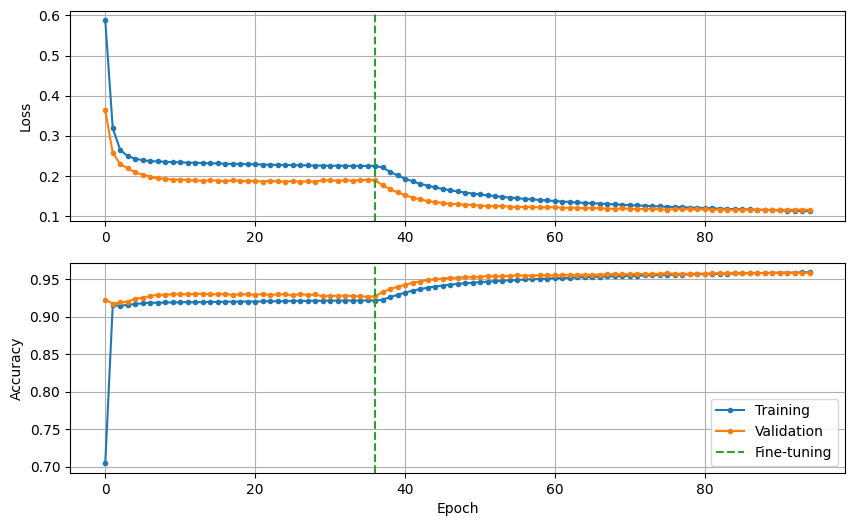

In [48]:
import matplotlib.pyplot as plt
# Plot learning curves
df = pd.DataFrame(history)
change = np.where(df.train_status=="pre")[0][-1]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
ax1.plot(df.epoch, df.loss, "-o", color="tab:blue", label="Train", markersize=3)
ax1.plot(df.epoch, df.val_loss, "-o", color="tab:orange", label="Validation", markersize=3)
ax1.axvline(x=change, linestyle="--", color="tab:green", label="Fine-tuning")
ax1.set_ylabel("Loss")
ax1.grid()

ax2.plot(df.epoch, df.categorical_accuracy, "-o", color="tab:blue", label="Training", markersize=3)
ax2.plot(df.epoch, df.val_categorical_accuracy, "-o", color="tab:orange", label="Validation", markersize=3)
ax2.axvline(x=change, linestyle="--", color="tab:green", label="Fine-tuning")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.grid()


In [35]:
# Create model for prediction

def load_prediction_model_for_study(study, weight_file, args, hparams):

    base = get_and_load_one_shot_model(
                n_periods=study.n_periods,
                project_dir=args.project_dir,
                hparams=hparams
                )
    clear_output(wait=False)    # Removing glorot intitialization warning...

    # Freeze base layers
    base.trainable = False

    base.layers[-5].trainable = True

    # Extract base from pre-trained model (remove last )
    inter_base = Model(inputs=base.input, outputs=base.layers[-5].output, name="uSleep_base")
    inter_out = inter_base(inputs=base.input, training=False)

    # Create new head with base model as input with a 2-class problem
    head=base.create_seq_modeling(in_=inter_out,
                                input_dims = base.input_dims,
                                data_per_period=args.data_per_prediction,
                                n_periods=base.n_periods,
                                n_classes=2,
                                transition_window=base.transition_window,
                                activation=base.activation,
                                regularizer=None)


    model = Model(inputs=base.input, outputs = head, name = "mU-Sleep")

    if weight_file is not None:
        model.trainable = True  # In order to load weights
        model.load_weights(weight_file)
        model.trainable = False
        

    print(f"Input shape: {model.input.shape}")
    print(f"Output shape: {model.output.shape}")
    print(f"Model trainable: {model.trainable}")
    _=[print(f"\t {x.name}: ({x.shape})") for x in model.trainable_weights]
    model.summary()

    return model

def predict_on_study(mdl, study: SleepStudy):

    prob = np.empty([len(study.channel_groups), study.n_periods*mdl.output_shape[-2], mdl.output_shape[-1]])
    for i, channel_group in enumerate(study.channel_groups):
        # Get PSG for particular group
        psg = np.expand_dims(study.get_all_periods(),0)
        psg_subset = psg[..., tuple(channel_group.channel_indices)]
        prob_i = mdl.predict_on_batch(psg_subset)
        prob[i,...] = prob_i.reshape(-1, prob.shape[-1])
    
    return prob


# Make validation predictions

ids = []
val_prob = []
val_y = []

for s in val_studies:

    pred_model = load_prediction_model_for_study(s, weight_file=pred_weights, args=args, hparams=hparams)

    prob = predict_on_study(pred_model, s)
    
    ids.append(s.identifier)
    val_prob.append(prob.mean(axis=0))
    val_y.append(s.y[...,1].flatten())
    


Input shape: (None, 80, 3840, 2)
Output shape: (None, 80, 30, 2)
Model trainable: False
Model: "mU-Sleep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 3840, 2)]     0         
                                                                 
 uSleep_base (Functional)    (None, 307200, 1, 6)      3119286   
                                                                 
 average_pool (AveragePoolin  (None, 2400, 1, 6)       0         
 g2D)                                                            
                                                                 
 sequence_conv_out_1 (Conv2D  (None, 2400, 1, 2)       14        
 )                                                               
                                                                 
 sequence_conv_out_2 (Conv2D  (None, 2400, 1, 2)       6         
 )                                  

Best Threshold=0.269638, F-Score=0.805


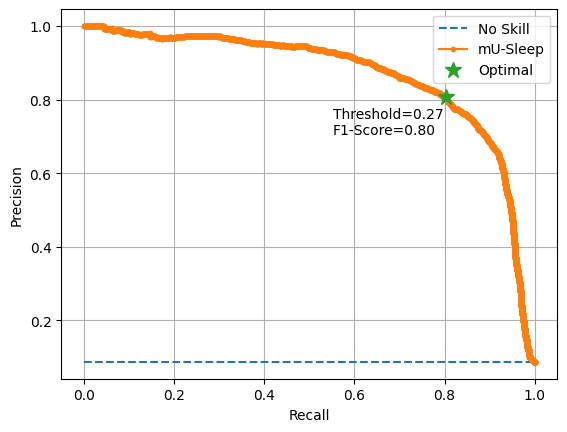

In [62]:
val_cat_y = np.concatenate(val_y)
val_cat_prob = np.concatenate(val_prob)

# pr curve for logistic regression model
from sklearn.metrics import precision_recall_curve

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(val_cat_y, val_cat_prob[:,1])

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
opt_idx = np.argmax(fscore)

# plot the roc curve for the model
no_skill = len(val_cat_y[val_cat_y==1]) / len(val_cat_y)
plt.subplots()
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='mU-Sleep')
plt.plot(recall[opt_idx], precision[opt_idx], marker="*", color="tab:green", markersize=12, label="Optimal", linestyle="none")

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()

print('Best Threshold=%f, F-Score=%.3f' % (thresholds[opt_idx], fscore[opt_idx]))
info_txt = f"Threshold={thresholds[opt_idx]:.2f}\nF1-Score={fscore[opt_idx]:.2f}" 
ty = -0.1
tx = -0.25
plt.text(recall[opt_idx]+tx, precision[opt_idx]+ty, info_txt)

# show the plot
plt.show()


In [39]:
# Make test predictions

test_ids = []
test_prob = []
test_y = []

for s in test_studies:

    pred_model = load_prediction_model_for_study(s, weight_file=pred_weights, args=args, hparams=hparams)

    prob = predict_on_study(pred_model, s)
    
    test_ids.append(s.psg_file_path.split("\\")[-1].replace(".edf",""))
    test_prob.append(prob.mean(axis=0))
    test_y.append(s.y[...,1].flatten())
    


Input shape: (None, 38, 3840, 2)
Output shape: (None, 38, 30, 2)
Model trainable: False
Model: "mU-Sleep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38, 3840, 2)]     0         
                                                                 
 uSleep_base (Functional)    (None, 145920, 1, 6)      3119286   
                                                                 
 average_pool (AveragePoolin  (None, 1140, 1, 6)       0         
 g2D)                                                            
                                                                 
 sequence_conv_out_1 (Conv2D  (None, 1140, 1, 2)       14        
 )                                                               
                                                                 
 sequence_conv_out_2 (Conv2D  (None, 1140, 1, 2)       6         
 )                                  

In [40]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, cohen_kappa_score

y_cat_prob = np.concatenate(test_prob)
y_cat_true = np.concatenate(test_y)
y_pred = y_cat_prob[:,1] >= thresholds[opt_idx]

print(f"Confusion matrix:\n{confusion_matrix(y_cat_true, y_pred)}")
print(f"F1-Score:\t{f1_score(y_cat_true, y_pred)}")
print(f"Precision:\t{precision_score(y_cat_true, y_pred)}")
print(f"Recall:\t\t{recall_score(y_cat_true, y_pred)}")
print(f"Cohen kappa:\t{cohen_kappa_score(y_cat_true, y_pred):.3f}")


Confusion matrix:
[[45298  1396]
 [  814  3222]]
F1-Score:	0.7446267621908944
Precision:	0.6977046340407103
Recall:		0.7983151635282458
Cohen kappa:	0.721


In [42]:
from scipy.io import savemat
# Write predictions to file
test_dict = {"id": test_ids,
            "probs": test_prob,
            "yTrue": test_y}

savemat("Matlab/status_comparison/transfer_learning_status.mat", test_dict)


In [ ]:
# from sklearn.metrics import f1_score, recall_score, precision_score, cohen_kappa_score
# y_pred = np.concatenate(y_prob)[:,1] > thresholds[ix]
# y_target = np.concatenate(y_true)
# print(f"Cohen kappa: {cohen_kappa_score(y_target, y_pred):.3f}")
# print(confusion_matrix(y_target, y_pred))
# print(f1_score(y_target, y_pred))
# print(precision_score(y_target, y_pred))
# print(recall_score(y_target, y_pred))

Cohen kappa: 0.676
[[46526   986]
 [  970  2248]]
0.6968381897086174
0.6951144094001237
0.6985705407085147


In [ ]:


# ## Initialize tf.Sequence object with list of SleepStudies with the following ´__get_item()__´ functionality
# #     1. Select random sleep study (or balanced?)
# #     2. Select random period with margin (limit the randomness within margins)
# #     3. Select random channels
# #     4. Extract psg based on the above
# #     5. Extract y (labels) with the same indexing as above
# #     6. Repeat for each batch
# import tensorflow as tf
# from tensorflow.keras.utils import Sequence

# class MyBaseSequence(Sequence):

#     def __init__(self, studies: typing.List[SleepStudy], hparams: YAMLHParams):
        
#         self.studies = studies
#         self.params  = hparams
#         self.batch_shape = hparams['build']['batch_shape']
#         self.batch_size = self.batch_shape[0]
#         self.period_size = self.batch_shape[1]
#         self.n_classes = 2
#         self.margin = np.floor((self.period_size / 2))
#         self.period_length_sec = hparams['prediction_params']['period_length']
#         self.num_entries = sum([(x.get_all_periods().shape[0] - self.margin*2) * x.n_channels for x in studies])
#         self.num_sequences = np.ceil(self.num_entries / self.batch_size)
        

#     def __len__(self):
#         return int(self.num_sequences)

#     # def get_study(self):
#     #     return

#     # def get_period_idx(self):
#     #     return
        
#     def _process_batch(self):

#         # Get study
#         _study = self.get_study()

#         # Get period
#         period_idx = self.get_period_idx(_study)

#         # Get channels
#         channels = self.get_channels(_study)
        
#         # Extract PSG from above
#         psg = _study.get_all_periods()
#         psg_subset = psg[int(period_idx-self.margin):int(period_idx+self.margin)+1,...,channels]

#         # Extract targets from above
#         target_subset = _study.y[int(period_idx-self.margin):int(period_idx+self.margin)+1,...]

#         return psg_subset, target_subset

#     def get_batches(self):

#         X = np.empty(shape=self.batch_shape)
#         Y = np.empty(shape=[self.batch_size, self.period_size, self.period_length_sec, self.n_classes])

#         for i in range(self.batch_size):
#             X[i,...], Y[i,...] = self._process_batch() 
        
#         return tf.convert_to_tensor(X), tf.convert_to_tensor(Y)

#     def __getitem__(self, idx):
#         return self.get_batches()


# class MyRandomBatchSequence(MyBaseSequence):

#     def __init__(self, studies: YAMLHParams, hparams: YAMLHParams):
#         super().__init__(studies, hparams)

#     def get_study(self):
#         return np.random.choice(self.studies, 1)[0]
    
#     def get_period_idx(self, study):
#         upper_margin_limit = int(study.n_periods - self.margin)
#         return np.random.randint(self.margin, upper_margin_limit, 1)

#     def get_channels(self, study):
#         # Select random channels
#         ch_idx = np.random.randint(0, len(study.channel_groups))
#         return study.channel_groups[ch_idx][1]


# class MyBalancedBatchSequence(MyBaseSequence):

#     def __init__(self, studies: YAMLHParams, hparams: YAMLHParams):
#         super().__init__(studies, hparams)
#         self._study_idx = 0
#         self._period_idx = self.margin
#         self._ch_idx = 0

#     def get_study(self):
#         return self.studies[self._study_idx]
    
#     def get_period_idx(self, study = None):
#         return self._period_idx

#     def get_channels(self, study):
#         return study.channel_groups[self._ch_idx][1]
    
#     def _shift(self):
        
#         self._ch_idx += 1
#         if self._ch_idx == 4:
#             self._ch_idx = 0
#             self._period_idx += 1
        
#         if self._period_idx == self.studies[self._study_idx].n_periods - self.margin:
#             self._study_idx += 1
#             self._period_idx = self.margin
#             self._ch_idx = 0

#         if self._study_idx == len(self.studies):
#             self._study_idx = 0
#             self._period_idx = self.margin
#             self._ch_idx = 0

#         return

#     def get_batches(self):

#         X = np.empty(shape=self.batch_shape)
#         Y = np.empty(shape=[self.batch_size, self.period_size, self.period_length_sec, self.n_classes])

#         for i in range(self.batch_size):
#             X[i,...], Y[i,...] = self._process_batch()
#             self._shift()
        
#         return tf.convert_to_tensor(X), tf.convert_to_tensor(Y)




# random_train_dataset = MyRandomBatchSequence(train_studies, hparams)
# random_val_dataset = MyRandomBatchSequence(val_studies, hparams)


# balanced_train_dataset = MyBalancedBatchSequence(train_studies, hparams)
# balanced_val_dataset = MyBalancedBatchSequence(val_studies, hparams)
